In [1]:
import os
from datetime import datetime
import pickle

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from prophet.utilities import regressor_coefficients

from flore_modeling import create_forecast

load_dotenv()


c:\Users\keita\anaconda3\envs\nuovo_ambiente\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


True

In [2]:
df = pd.read_csv('df_inno_flore1.csv', sep=',')
df = df.fillna(0)

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

<Axes: xlabel='Date'>

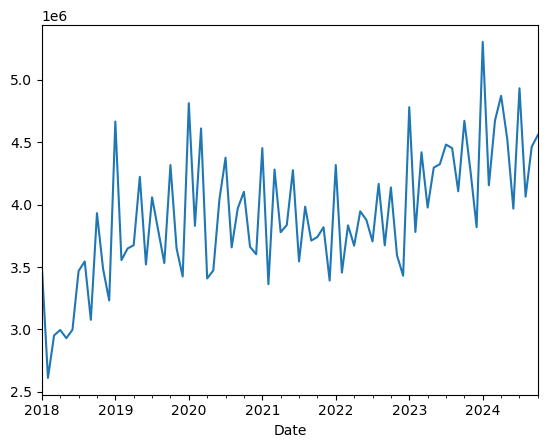

In [4]:
df.set_index('Date')['Ex-factory volumes'].plot()

This time series is clearly not stationary, does not have a strong seasonality but there is an upwards trend

## Feature selection

In [6]:
regressors = [col for col in df.columns if col not in ['Date', 'Ex-factory volumes']]


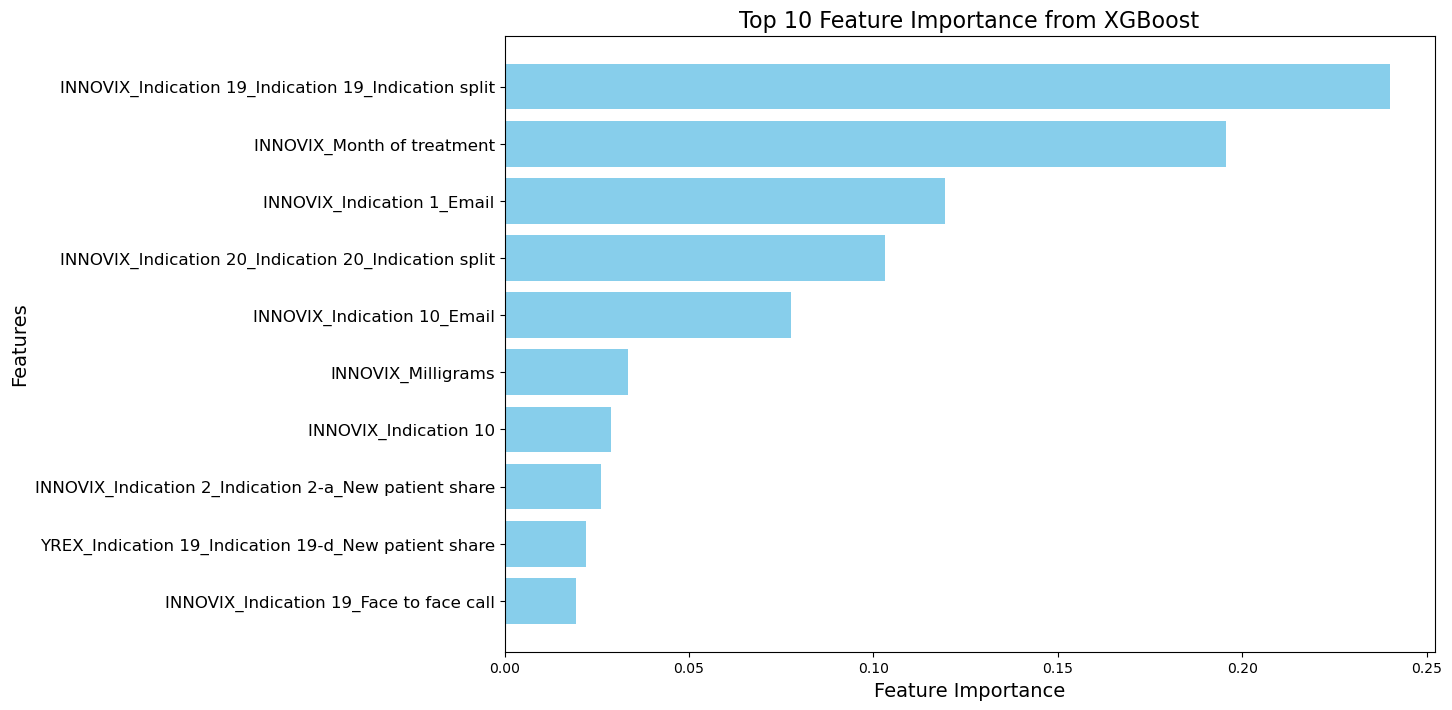

Selected Features for Prophet: ['INNOVIX_Indication 19_Indication 19_Indication split', 'INNOVIX_Month of treatment', 'INNOVIX_Indication 1_Email', 'INNOVIX_Indication 20_Indication 20_Indication split', 'INNOVIX_Indication 10_Email', 'INNOVIX_Milligrams', 'INNOVIX_Indication 10', 'INNOVIX_Indication 2_Indication 2-a_New patient share', 'YREX_Indication 19_Indication 19-d_New patient share', 'INNOVIX_Indication 19_Face to face call']


In [7]:
X = df[regressors]
y = df['Ex-factory volumes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
xgb_model = XGBRegressor(random_state=42, n_estimators=100, max_depth=3)
xgb_model.fit(X_train, y_train)

# Feature importance
feature_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': regressors, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_features = 10
top_importance_df = importance_df.head(top_features)

plt.figure(figsize=(12, 8))
plt.barh(top_importance_df['Feature'], top_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 10 Feature Importance from XGBoost', fontsize=16)

plt.tick_params(axis='y', labelsize=12)
plt.gca().invert_yaxis()
plt.show()

selected_features = importance_df['Feature'].head(10).tolist()

print(f"Selected Features for Prophet: {selected_features}")

**Why Remove Collinearity in Time Series Forecasting?**  

- **Improves model stability**: Prevents unstable or unreliable coefficients.  
- **Enhances prediction accuracy**: Reduces overfitting and improves generalization.  
- **Increases interpretability**: Clarifies the impact of each regressor.  
- **Avoids redundancy**: Removes unnecessary or duplicate information.  
- **Boosts efficiency**: Simplifies the model and reduces computational complexity.  

Filtered Features for Prophet: ['INNOVIX_Indication 19_Indication 19_Indication split', 'INNOVIX_Month of treatment', 'INNOVIX_Indication 1_Email', 'INNOVIX_Indication 10_Email', 'INNOVIX_Milligrams', 'INNOVIX_Indication 10', 'INNOVIX_Indication 2_Indication 2-a_New patient share', 'YREX_Indication 19_Indication 19-d_New patient share', 'INNOVIX_Indication 19_Face to face call']
Removed Correlated Features: {'INNOVIX_Indication 20_Indication 20_Indication split'}


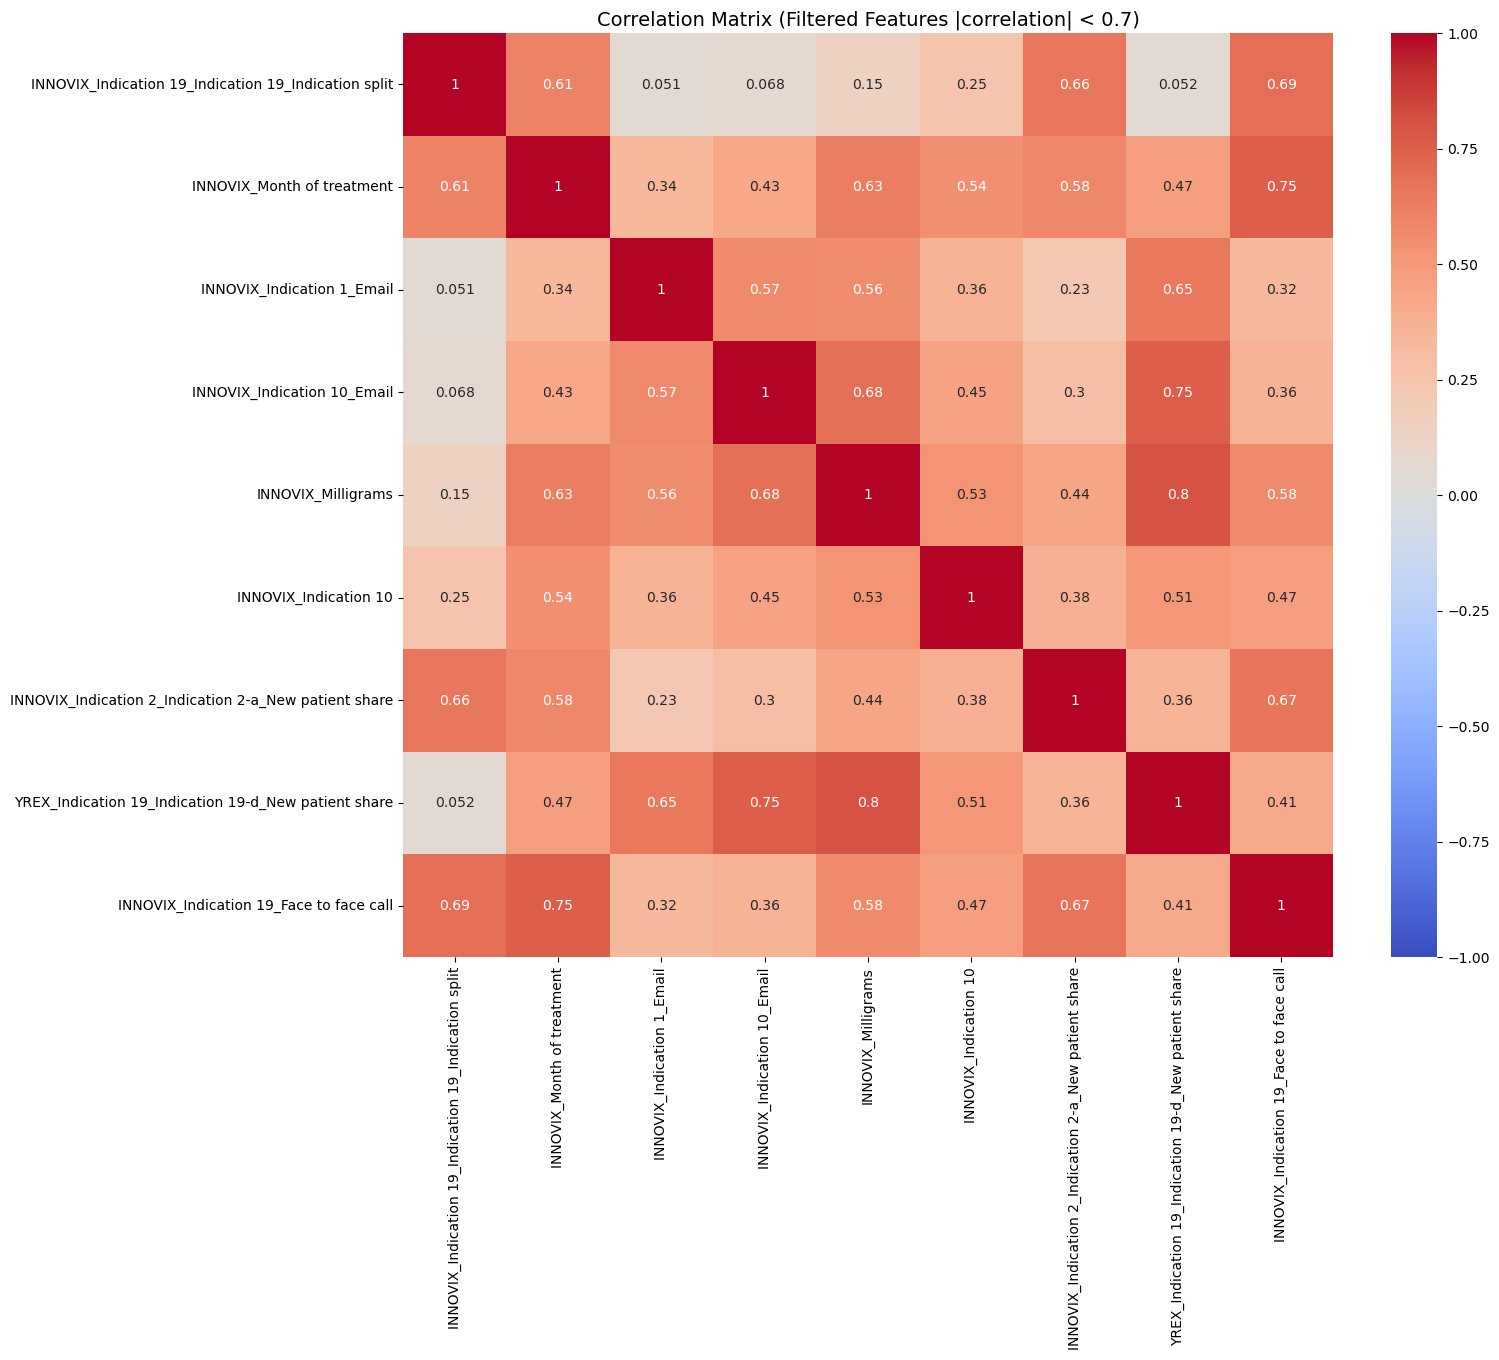

In [12]:
# Correlation matrix for features
corr_matrix = df[selected_features].corr()

correlated_features = set()
threshold = 0.8

target_corr = df[selected_features].corrwith(df['Ex-factory volumes'])

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]

            # Delete the feature less important with the target
            if abs(target_corr[col_i]) > abs(target_corr[col_j]):
                correlated_features.add(col_j)
            else:
                correlated_features.add(col_i)

filtered_features = [col for col in selected_features if col not in correlated_features]

print(f"Filtered Features for Prophet: {filtered_features}")
print(f"Removed Correlated Features: {correlated_features}")

filtered_corr = df[filtered_features].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix (Filtered Features |correlation| < 0.7)', fontsize=14)
plt.show()

In [14]:
REGRESSORS = ['INNOVIX_Indication 10_Email',
 'INNOVIX_Indication 10_Face to face call',
 'INNOVIX_Indication 10_Remote call',
 'INNOVIX_Indication 12_Email',
 'INNOVIX_Indication 12_Face to face call',
 'INNOVIX_Indication 12_Meetings',
 'INNOVIX_Indication 12_Remote call',
 'INNOVIX_Indication 19_Email',
 'INNOVIX_Indication 1_Remote call',
 'INNOVIX_Indication 12_Indication 12_New patient share',
 'INNOVIX_Indication 2_Indication 2-b_New patient share',
 'YREX_Indication 10']

### COEFFICIENTS 

1. **Positive Impact: Regressors with Positive Coefficients**  
   Some regressors have a positive influence on the target variable. For these regressors, as their values increase, the predicted value of the target variable also increases.  
   **Examples:**  
   - `INNOVIX_Indication 12_Email` and `YREX_Indication 10` are notable contributors, indicating a direct positive impact on the outcome.  
   - `INNOVIX_Indication 12_Meetings` exhibits a very high positive impact, suggesting it could be a key driver of the target variable.

2. **Negative Impact: Regressors with Negative Coefficients**  
   These regressors reduce the predicted value of the target variable. A higher value for these regressors results in a decrease in the outcome.  
   **Examples:**  
   - `INNOVIX_Indication 10_Remote call` and `INNOVIX_Indication 1_Remote call` show significant negative effects.  
   - `INNOVIX_Indication 12_Face to face call` also has a negative impact, though to a lesser extent compared to others.

3. **Magnitude of Coefficients: High Magnitude Coefficients**  
   Some regressors have exceptionally high absolute coefficients, indicating that even small changes in their values can significantly impact the target variable.  
   **Examples:**  
   - `INNOVIX_Indication 12_Indication 12_New patient` has a very high positive coefficient, suggesting it is one of the most critical drivers.  
   - `INNOVIX_Indication 10_Email` also has a large positive coefficient, reinforcing its importance in the model.


In [13]:
#Reload the model
with open('prophet_model_flore.pkl', 'rb') as f:
    m = pickle.load(f)

coefficients = regressor_coefficients(m)
coefficients


,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,INNOVIX_Indication 10_Email,additive,3.923077,6.505690e+03,6.505690e+03,6.505690e+03
1,INNOVIX_Indication 10_Face to face call,additive,82.038462,-5.804437e+01,-5.804437e+01,-5.804437e+01
2,INNOVIX_Indication 10_Remote call,additive,22.261538,-9.165672e+02,-9.165672e+02,-9.165672e+02
3,INNOVIX_Indication 12_Email,additive,5.046154,2.960313e+02,2.960313e+02,2.960313e+02
4,INNOVIX_Indication 12_Face to face call,additive,107.284615,-4.108273e+02,-4.108273e+02,-4.108273e+02
5,INNOVIX_Indication 12_Meetings,additive,3.076923,2.387101e+04,2.387101e+04,2.387101e+04
6,INNOVIX_Indication 12_Remote call,additive,64.146154,7.945313e+02,7.945313e+02,7.945313e+02
7,INNOVIX_Indication 19_Email,additive,23.738462,4.182203e+02,4.182203e+02,4.182203e+02
8,INNOVIX_Indication 1_Remote call,additive,42.876923,-1.127142e+03,-1.127142e+03,-1.127142e+03
9,INNOVIX_Indication 12_Indication 12_New patien...,additive,0.203244,1.624931e+06,1.624931e+06,1.624931e+06


In [ ]:
forecast, forecast_complete = create_forecast(m, regressors_filtered, "2025-12-01", "2027-12-01")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

           ds          yhat    yhat_lower    yhat_upper
0  2025-12-01  3.746414e+06  3.398633e+06  4.072473e+06
1  2026-01-01  4.598304e+06  4.284060e+06  4.923535e+06
2  2026-02-01  3.490436e+06  3.167354e+06  3.845705e+06
3  2026-03-01  3.985120e+06  3.650970e+06  4.319635e+06
4  2026-04-01  3.683174e+06  3.337457e+06  3.987457e+06
5  2026-05-01  3.983439e+06  3.635851e+06  4.339203e+06
6  2026-06-01  3.924098e+06  3.602633e+06  4.237387e+06
7  2026-07-01  4.073090e+06  3.746865e+06  4.412244e+06
8  2026-08-01  4.222262e+06  3.914149e+06  4.522017e+06
9  2026-09-01  3.841214e+06  3.528688e+06  4.171284e+06
10 2026-10-01  4.396300e+06  4.072907e+06  4.720041e+06
11 2026-11-01  3.776534e+06  3.418761e+06  4.107764e+06
12 2026-12-01  3.717274e+06  3.354195e+06  4.024581e+06
13 2027-01-01  4.895252e+06  4.525359e+06  5.218293e+06
14 2027-02-01  3.721952e+06  3.408569e+06  4.035969e+06
15 2027-03-01  3.747554e+06  3.438378e+06  4.076228e+06
16 2027-04-01  3.945810e+06  3.618194e+06  4.267

## Forecast

In [15]:
file_path = 'INNOVIX_Floresland.xlsx'

excel_file = pd.ExcelFile(file_path)

forecast_volumes_df = pd.read_excel(file_path, sheet_name='Forecast volumes')

transformed_df = forecast_volumes_df[['Forecast Algorithm', 'Date', 'Value']]

transformed_df

,Forecast Algorithm,Date,Value
0,optimized tslmx,2024-11-01,4.279858e+06
1,optimized tslmx,2024-12-01,4.095373e+06
2,optimized tslmx,2025-01-01,4.245648e+06
3,optimized tslmx,2025-02-01,4.208594e+06
4,optimized tslmx,2025-03-01,4.487799e+06
...,...,...,...
135,optimized tslmx,2025-08-01,4.120404e+06
136,optimized tslmx,2025-09-01,4.150404e+06
137,optimized tslmx,2025-10-01,4.182603e+06
138,optimized tslmx,2025-11-01,3.998966e+06


In [16]:
fixed_values = {
    'INNOVIX_Indication 10_Email': 10,
    'YREX_Indication 10': 5
}

forecast, forecast_complete = create_forecast(m, REGRESSORS, "2024-11-01", "2025-12-01",
    fixed_regressors=fixed_values,
    default_value=0)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

prophet_forecast = forecast.rename(columns={
    'ds': 'Date',
    'yhat': 'Value'
})
prophet_forecast['Forecast Algorithm'] = 'prophet'

final_df = pd.concat([transformed_df, prophet_forecast[['Forecast Algorithm', 'Date', 'Value']]], ignore_index=True)
final_df

,Forecast Algorithm,Date,Value
0,optimized tslmx,2024-11-01,4.279858e+06
1,optimized tslmx,2024-12-01,4.095373e+06
2,optimized tslmx,2025-01-01,4.245648e+06
3,optimized tslmx,2025-02-01,4.208594e+06
4,optimized tslmx,2025-03-01,4.487799e+06
...,...,...,...
149,prophet,2025-08-01,5.652546e+06
150,prophet,2025-09-01,5.546227e+06
151,prophet,2025-10-01,5.807075e+06
152,prophet,2025-11-01,5.361723e+06


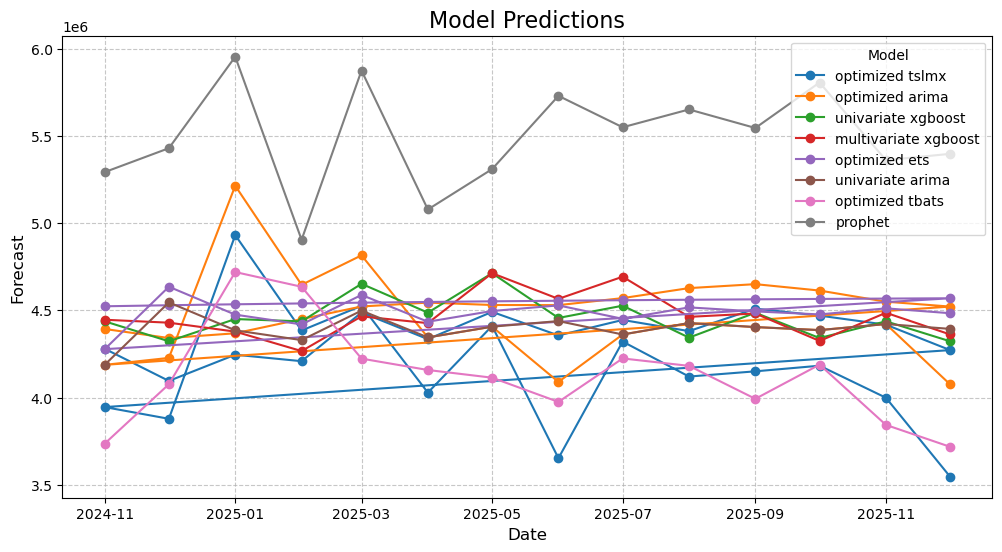

In [17]:
final_df['Date'] = pd.to_datetime(final_df['Date'])

plt.figure(figsize=(12, 6))

for model in final_df['Forecast Algorithm'].unique():
    model_data = final_df[final_df['Forecast Algorithm'] == model]
    plt.plot(model_data['Date'], model_data['Value'], label=model, marker='o')

plt.title('Model Predictions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecast', fontsize=12)
plt.legend(title='Model', fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.7)

plt.show()